#PARTE 1

In [ ]:
print("=" * 80)
print("PARTE 1A: Instalando dependencias necesarias")
print("=" * 80)

import sys
!{sys.executable} -m pip install -q faiss-cpu scikit-image tqdm opencv-python-headless joblib

import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import joblib
from tqdm import tqdm
import time
import os
import warnings
warnings.filterwarnings('ignore')

print("Todas las dependencias instaladas correctamente\n")

PARTE 1A: Instalando dependencias necesarias
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 31.4/31.4 MB 61.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.0/54.0 MB 80.3 MB/s eta 0:00:00
✅ Todas las dependencias instaladas correctamente



In [ ]:
print("=" * 80)
print("PARTE 1B: Configuración del proyecto")
print("=" * 80)

class Config:

    DATA_DIR = './data'
    CACHE_DIR = './cache'
    RESULTS_DIR = './results'

    SIFT_SCALES = 5
    SIFT_STRIDE = 8
    SIFT_PATCH_SIZE = 16

    N_GAUSSIANS = 256
    N_CLUSTERS_BOVW = 1024
    SAMPLE_SIZE = 10000
    PCA_DIM = 64

    MAX_DESCRIPTORS = 1_000_000
    EXTRACT_BATCH_SIZE = 500

    SVM_C_VALUES = [0.1, 1, 10, 100]

    USE_ENSEMBLE = True

    RANDOM_SEED = 42


    @staticmethod
    def setup_directories():
        for d in [Config.DATA_DIR, Config.CACHE_DIR, Config.RESULTS_DIR]:
            os.makedirs(d, exist_ok=True)
        print(f"Directorios creados: {Config.DATA_DIR}, {Config.CACHE_DIR}, {Config.RESULTS_DIR}")


Config.setup_directories()


np.random.seed(Config.RANDOM_SEED)
print(f" Random seed configurado: {Config.RANDOM_SEED}\n")

PARTE 1B: Configuración del proyecto
✅ Directorios creados: ./data, ./cache, ./results
✅ Random seed configurado: 42



In [ ]:
print("=" * 80)
print("PARTE 1C: Descargando y cargando dataset STL-10")
print("=" * 80)

import torch
from torchvision import datasets, transforms

def load_stl10_data():
    print("Descargando STL-10 dataset...")
    print("   - Train: 5,000 imágenes (10 clases, 500 por clase)")
    print("   - Test: 8,000 imágenes (10 clases, 800 por clase)")
    print("   - Unlabeled: 100,000 imágenes (para aprendizaje no supervisado)")


    transform = transforms.Compose([
        transforms.ToTensor(),
    ])


    train_data = datasets.STL10(
        root=Config.DATA_DIR,
        split='train',
        download=True,
        transform=transform
    )

    test_data = datasets.STL10(
        root=Config.DATA_DIR,
        split='test',
        download=True,
        transform=transform
    )

    unlabeled_data = datasets.STL10(
        root=Config.DATA_DIR,
        split='unlabeled',
        download=True,
        transform=transform
    )

    print(f"Dataset cargado exitosamente")
    print(f"   - Train size: {len(train_data)}")
    print(f"   - Test size: {len(test_data)}")
    print(f"   - Unlabeled size: {len(unlabeled_data)}")

    return train_data, test_data, unlabeled_data


train_data, test_data, unlabeled_data = load_stl10_data()

class_names = ['airplane', 'bird', 'car', 'cat', 'deer',
               'dog', 'horse', 'monkey', 'ship', 'truck']
print(f"\nClases: {class_names}\n")

PARTE 1C: Descargando y cargando dataset STL-10
📥 Descargando STL-10 dataset...
   - Train: 5,000 imágenes (10 clases, 500 por clase)
   - Test: 8,000 imágenes (10 clases, 800 por clase)
   - Unlabeled: 100,000 imágenes (para aprendizaje no supervisado)


100%|██████████| 2.64G/2.64G [03:33<00:00, 12.3MB/s]


✅ Dataset cargado exitosamente
   - Train size: 5000
   - Test size: 8000
   - Unlabeled size: 100000

📊 Clases: ['airplane', 'bird', 'car', 'cat', 'deer', 'dog', 'horse', 'monkey', 'ship', 'truck']



PARTE 1D: Exploración del dataset


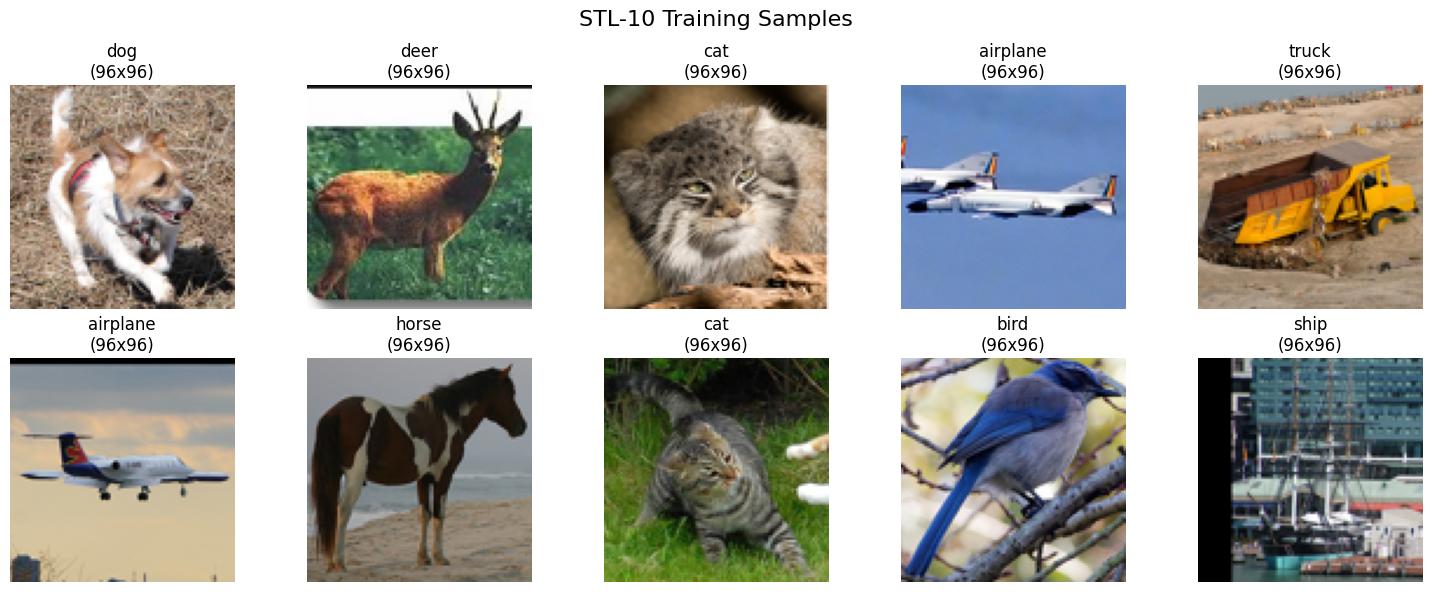

✅ Visualización guardada en ./results/dataset_samples.png

📊 Estadísticas del Dataset:
------------------------------------------------------------
Dimensiones de imagen: 96x96x3
Formato: RGB (0-1)

Distribución de clases (Train):
  airplane    :  500 imágenes
  bird        :  500 imágenes
  car         :  500 imágenes
  cat         :  500 imágenes
  deer        :  500 imágenes
  dog         :  500 imágenes
  horse       :  500 imágenes
  monkey      :  500 imágenes
  ship        :  500 imágenes
  truck       :  500 imágenes

Distribución de clases (Test):
  airplane    :  800 imágenes
  bird        :  800 imágenes
  car         :  800 imágenes
  cat         :  800 imágenes
  deer        :  800 imágenes
  dog         :  800 imágenes
  horse       :  800 imágenes
  monkey      :  800 imágenes
  ship        :  800 imágenes
  truck       :  800 imágenes
------------------------------------------------------------


In [ ]:
print("=" * 80)
print("PARTE 1D: Exploración del dataset")
print("=" * 80)

def visualize_samples(dataset, n_samples=10, title="Ejemplos del dataset"):

    fig, axes = plt.subplots(2, 5, figsize=(15, 6))
    fig.suptitle(title, fontsize=16)

    indices = np.random.choice(len(dataset), n_samples, replace=False)

    for idx, ax in zip(indices, axes.flat):
        img, label = dataset[idx]

        img_np = img.permute(1, 2, 0).numpy()

        ax.imshow(img_np)
        ax.set_title(f"{class_names[label]}\n({img_np.shape[0]}x{img_np.shape[1]})")
        ax.axis('off')

    plt.tight_layout()
    plt.savefig(f'{Config.RESULTS_DIR}/dataset_samples.png', dpi=150, bbox_inches='tight')
    plt.show()
    print(f"✅ Visualización guardada en {Config.RESULTS_DIR}/dataset_samples.png")

visualize_samples(train_data, title="STL-10 Training Samples")


def print_dataset_stats(train_data, test_data, unlabeled_data):

    print("\nEstadísticas del Dataset:")
    print("-" * 60)


    sample_img, _ = train_data[0]
    print(f"Dimensiones de imagen: {sample_img.shape[1]}x{sample_img.shape[2]}x{sample_img.shape[0]}")
    print(f"Formato: RGB (0-1)")


    train_labels = [train_data[i][1] for i in range(len(train_data))]
    unique, counts = np.unique(train_labels, return_counts=True)
    print(f"\nDistribución de clases (Train):")
    for class_id, count in zip(unique, counts):
        print(f"  {class_names[class_id]:12s}: {count:4d} imágenes")


    test_labels = [test_data[i][1] for i in range(len(test_data))]
    unique, counts = np.unique(test_labels, return_counts=True)
    print(f"\nDistribución de clases (Test):")
    for class_id, count in zip(unique, counts):
        print(f"  {class_names[class_id]:12s}: {count:4d} imágenes")

    print("-" * 60)

print_dataset_stats(train_data, test_data, unlabeled_data)

In [ ]:
print("\n" + "=" * 80)
print("PARTE 1E: Funciones auxiliares de procesamiento")
print("=" * 80)

def tensor_to_gray(img_tensor):
    img_np = img_tensor.permute(1, 2, 0).numpy()
    img_np = (img_np * 255).astype(np.uint8)
    img_gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
    return img_gray

def check_cache(cache_path):

    return os.path.exists(cache_path)

def save_cache(data, cache_path, compress=3):

    joblib.dump(data, cache_path, compress=compress)
    print(f"💾 Cache guardado: {cache_path}")

def load_cache(cache_path):

    print(f"📂 Cargando desde cache: {cache_path}")
    return joblib.load(cache_path)

def format_time(seconds):

    if seconds < 60:
        return f"{seconds:.1f}s"
    elif seconds < 3600:
        return f"{seconds/60:.1f}m"
    else:
        return f"{seconds/3600:.1f}h"

print("✅ Funciones auxiliares definidas correctamente")

print("\n" + "=" * 80)
print("✅ PARTE 1 COMPLETADA - Setup y Data Loading")
print("=" * 80)
print("\n📋 Resumen:")
print(f"  ✓ Dependencias instaladas")
print(f"  ✓ Configuración establecida (SIFT scales={Config.SIFT_SCALES}, GMM={Config.N_GAUSSIANS})")
print(f"  ✓ Dataset STL-10 descargado y cargado")
print(f"  ✓ {len(train_data)} imágenes de entrenamiento")
print(f"  ✓ {len(test_data)} imágenes de test")
print(f"  ✓ {len(unlabeled_data)} imágenes sin etiquetar")
print(f"  ✓ Funciones auxiliares listas")
print(f"\n🚀 Siguiente paso: Ejecutar Parte 2 - Extracción de Descriptores")
print("=" * 80)


PARTE 1E: Funciones auxiliares de procesamiento
✅ Funciones auxiliares definidas correctamente

✅ PARTE 1 COMPLETADA - Setup y Data Loading

📋 Resumen:
  ✓ Dependencias instaladas
  ✓ Configuración establecida (SIFT scales=5, GMM=256)
  ✓ Dataset STL-10 descargado y cargado
  ✓ 5000 imágenes de entrenamiento
  ✓ 8000 imágenes de test
  ✓ 100000 imágenes sin etiquetar
  ✓ Funciones auxiliares listas

🚀 Siguiente paso: Ejecutar Parte 2 - Extracción de Descriptores


#PARTE 2

In [ ]:
import numpy as np
import cv2
from tqdm import tqdm
import time
import joblib

In [ ]:

import numpy as np
import cv2
from tqdm import tqdm
import time
import joblib


print("=" * 80)
print("PARTE 2A: Implementación de Dense RootSIFT")
print("=" * 80)

class DenseRootSIFT:

    def __init__(self, scales=5, stride=8, patch_size=16):

        self.scales = scales
        self.stride = stride
        self.patch_size = patch_size
        self.sift = cv2.SIFT_create()

    def extract_dense_sift(self, img_gray):
        h, w = img_gray.shape


        keypoints = []
        for y in range(0, h - self.patch_size, self.stride):
            for x in range(0, w - self.patch_size, self.stride):
                keypoints.append(cv2.KeyPoint(x, y, self.patch_size))


        _, descriptors = self.sift.compute(img_gray, keypoints)

        return descriptors

    def rootsift_normalize(self, descriptors):

        if descriptors is None:
            return None

        # L1 normalization
        descriptors = descriptors / (descriptors.sum(axis=1, keepdims=True) + 1e-7)

        descriptors = np.sqrt(descriptors)

        # L2 normalization
        descriptors = descriptors / (np.linalg.norm(descriptors, axis=1, keepdims=True) + 1e-7)

        return descriptors

    def extract_multiscale(self, img_gray):
        all_descriptors = []

        for scale_idx in range(self.scales):

            scale_factor = 2 ** (scale_idx * 0.5)

            new_h = int(img_gray.shape[0] * scale_factor)
            new_w = int(img_gray.shape[1] * scale_factor)

            if new_h < self.patch_size or new_w < self.patch_size:
                continue

            img_scaled = cv2.resize(img_gray, (new_w, new_h))


            descriptors = self.extract_dense_sift(img_scaled)

            if descriptors is not None and len(descriptors) > 0:

                rootsift_desc = self.rootsift_normalize(descriptors)
                all_descriptors.append(rootsift_desc)

        if len(all_descriptors) > 0:
            return np.vstack(all_descriptors)
        else:
            return None

    def __call__(self, img_gray):
        return self.extract_multiscale(img_gray)


sift_extractor = DenseRootSIFT(
    scales=Config.SIFT_SCALES,
    stride=Config.SIFT_STRIDE,
    patch_size=Config.SIFT_PATCH_SIZE
)

print(f"Dense RootSIFT configurado:")
print(f"   - Escalas: {Config.SIFT_SCALES}")
print(f"   - Stride: {Config.SIFT_STRIDE} píxeles")
print(f"   - Patch size: {Config.SIFT_PATCH_SIZE}x{Config.SIFT_PATCH_SIZE}")

PARTE 2A: Implementación de Dense RootSIFT
✅ Dense RootSIFT configurado:
   - Escalas: 5
   - Stride: 8 píxeles
   - Patch size: 16x16


In [ ]:
print("\n" + "=" * 80)
print("PARTE 2B: Extracción de descriptores de unlabeled data")
print("=" * 80)

def extract_descriptors_from_dataset(dataset, n_samples, extractor, desc="Extracting"):

    indices = np.random.choice(len(dataset), min(n_samples, len(dataset)), replace=False)

    all_descriptors = []

    for idx in tqdm(indices, desc=desc):
        img_tensor, _ = dataset[idx]
        img_gray = tensor_to_gray(img_tensor)


        descriptors = extractor(img_gray)

        if descriptors is not None and len(descriptors) > 0:
            all_descriptors.append(descriptors)

    return all_descriptors


descriptors_cache = f'{Config.CACHE_DIR}/unlabeled_descriptors_{Config.SAMPLE_SIZE}.pkl'

if check_cache(descriptors_cache):
    print(f"📂 Cargando descriptores desde cache...")
    unlabeled_descriptors = load_cache(descriptors_cache)
    print(f"✅ Cargado: {len(unlabeled_descriptors)} imágenes con descriptores")
else:
    print(f"🔄 Extrayendo Dense RootSIFT de {Config.SAMPLE_SIZE} imágenes unlabeled...")
    print(f"⏱️  Tiempo estimado: {format_time(Config.SAMPLE_SIZE * 0.5)} (aprox.)")

    start_time = time.time()

    unlabeled_descriptors = extract_descriptors_from_dataset(
        unlabeled_data,
        n_samples=Config.SAMPLE_SIZE,
        extractor=sift_extractor,
        desc="Extracting SIFT from unlabeled"
    )

    elapsed = time.time() - start_time


    save_cache(unlabeled_descriptors, descriptors_cache)

    print(f"✅ Extracción completada en {format_time(elapsed)}")
    print(f"   - {len(unlabeled_descriptors)} imágenes procesadas")
    print(f"   - Tiempo promedio: {elapsed/len(unlabeled_descriptors):.2f}s por imagen")


total_descriptors = sum(len(desc) for desc in unlabeled_descriptors)
avg_per_image = total_descriptors / len(unlabeled_descriptors)

print(f"\n📊 Estadísticas de descriptores:")
print(f"   - Total descriptores: {total_descriptors:,}")
print(f"   - Promedio por imagen: {avg_per_image:.0f}")
print(f"   - Dimensionalidad: 128D (SIFT estándar)")


PARTE 2B: Extracción de descriptores de unlabeled data
🔄 Extrayendo Dense RootSIFT de 10000 imágenes unlabeled...
⏱️  Tiempo estimado: 1.4h (aprox.)


Extracting SIFT from unlabeled: 100%|██████████| 10000/10000 [05:43<00:00, 29.09it/s]


💾 Cache guardado: ./cache/unlabeled_descriptors_10000.pkl
✅ Extracción completada en 5.7m
   - 10000 imágenes procesadas
   - Tiempo promedio: 0.03s por imagen

📊 Estadísticas de descriptores:
   - Total descriptores: 39,490,000
   - Promedio por imagen: 3949
   - Dimensionalidad: 128D (SIFT estándar)


In [ ]:
print("\n" + "=" * 80)
print("PARTE 2C: Preparación de descriptores para training")
print("=" * 80)

def pool_descriptors(descriptor_list, max_descriptors=1_000_000):
    print(f"🔄 Pooling descriptores...")


    all_desc = np.vstack(descriptor_list)

    print(f"   - Total descriptores: {len(all_desc):,}")


    if len(all_desc) > max_descriptors:
        print(f"   - Sampling a {max_descriptors:,} descriptores...")
        indices = np.random.choice(len(all_desc), max_descriptors, replace=False)
        all_desc = all_desc[indices]

    print(f"✅ Descriptores pooled: {all_desc.shape}")
    return all_desc

pooled_descriptors = pool_descriptors(
    unlabeled_descriptors,
    max_descriptors=2_000_000
)


PARTE 2C: Preparación de descriptores para training
🔄 Pooling descriptores...
   - Total descriptores: 39,490,000
   - Sampling a 2,000,000 descriptores...
✅ Descriptores pooled: (2000000, 128)


In [ ]:
print("\n" + "=" * 80)
print("PARTE 2D: Reducción de dimensionalidad con PCA")
print("=" * 80)

pca_cache = f'{Config.CACHE_DIR}/pca_model_{Config.PCA_DIM}d.pkl'

if check_cache(pca_cache):
    print(f"📂 Cargando modelo PCA desde cache...")
    pca = load_cache(pca_cache)
    print(f"✅ PCA cargado: 128D → {Config.PCA_DIM}D")
else:
    print(f"🔄 Entrenando PCA: 128D → {Config.PCA_DIM}D con whitening...")
    print(f"⏱️  Tiempo estimado: {format_time(len(pooled_descriptors) * 0.00001)}")

    start_time = time.time()


    pca = PCA(n_components=Config.PCA_DIM, whiten=True, random_state=Config.RANDOM_SEED)

    pca.fit(pooled_descriptors)

    elapsed = time.time() - start_time

    save_cache(pca, pca_cache)

    print(f"✅ PCA entrenado en {format_time(elapsed)}")
    print(f"   - Varianza explicada: {pca.explained_variance_ratio_.sum():.2%}")


print(f"\n🔄 Transformando descriptores con PCA...")
pooled_descriptors_pca = pca.transform(pooled_descriptors)
print(f"✅ Descriptores reducidos: {pooled_descriptors_pca.shape}")

del pooled_descriptors
import gc
gc.collect()


PARTE 2D: Reducción de dimensionalidad con PCA
🔄 Entrenando PCA: 128D → 64D con whitening...
⏱️  Tiempo estimado: 20.0s
💾 Cache guardado: ./cache/pca_model_64d.pkl
✅ PCA entrenado en 0.8s
   - Varianza explicada: 95.61%

🔄 Transformando descriptores con PCA...
✅ Descriptores reducidos: (2000000, 64)


20077


PARTE 2E: Visualización de descriptores


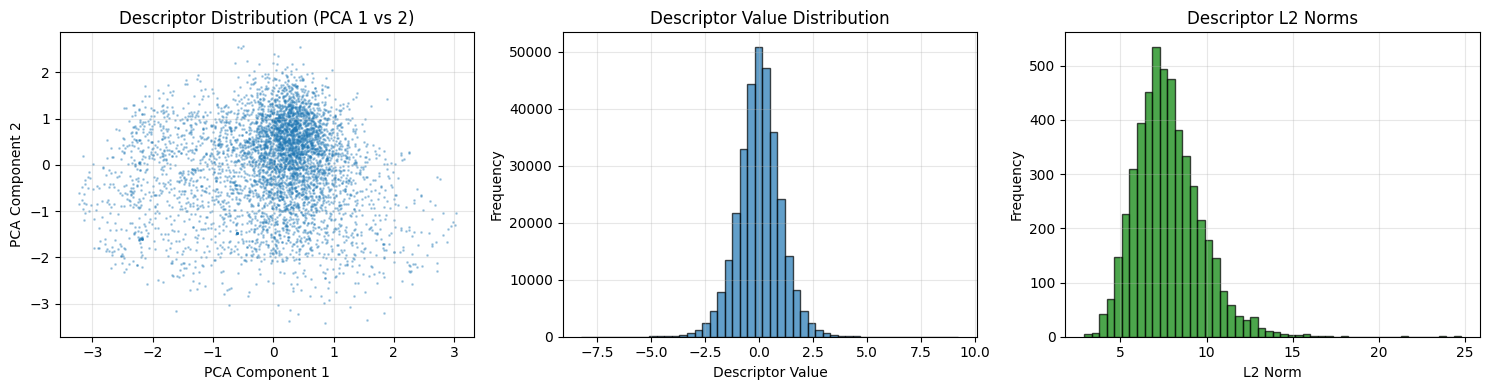

✅ Visualización guardada en ./results/descriptor_distribution.png


In [ ]:
print("\n" + "=" * 80)
print("PARTE 2E: Visualización de descriptores")
print("=" * 80)

def visualize_descriptor_distribution(descriptors_pca, n_samples=5000):

    if len(descriptors_pca) > n_samples:
        indices = np.random.choice(len(descriptors_pca), n_samples, replace=False)
        sample = descriptors_pca[indices]
    else:
        sample = descriptors_pca

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))

    axes[0].scatter(sample[:, 0], sample[:, 1], alpha=0.3, s=1)
    axes[0].set_xlabel('PCA Component 1')
    axes[0].set_ylabel('PCA Component 2')
    axes[0].set_title('Descriptor Distribution (PCA 1 vs 2)')
    axes[0].grid(True, alpha=0.3)

    axes[1].hist(sample.flatten(), bins=50, alpha=0.7, edgecolor='black')
    axes[1].set_xlabel('Descriptor Value')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title('Descriptor Value Distribution')
    axes[1].grid(True, alpha=0.3)

    norms = np.linalg.norm(sample, axis=1)
    axes[2].hist(norms, bins=50, alpha=0.7, color='green', edgecolor='black')
    axes[2].set_xlabel('L2 Norm')
    axes[2].set_ylabel('Frequency')
    axes[2].set_title('Descriptor L2 Norms')
    axes[2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(f'{Config.RESULTS_DIR}/descriptor_distribution.png', dpi=150, bbox_inches='tight')
    plt.show()

    print(f"✅ Visualización guardada en {Config.RESULTS_DIR}/descriptor_distribution.png")

visualize_descriptor_distribution(pooled_descriptors_pca)


In [ ]:
print("\n" + "=" * 80)
print("✅ PARTE 2 COMPLETADA - Extracción de Descriptores")
print("=" * 80)
print("\n📋 Resumen:")
print(f"  ✓ Dense RootSIFT implementado")
print(f"  ✓ {len(unlabeled_descriptors)} imágenes procesadas")
print(f"  ✓ {len(pooled_descriptors_pca):,} descriptores extraídos y reducidos")
print(f"  ✓ PCA entrenado: 128D → {Config.PCA_DIM}D")
print(f"  ✓ Varianza explicada: {pca.explained_variance_ratio_.sum():.2%}")
print(f"  ✓ Modelos guardados en cache para reutilización")
print(f"\n🚀 Siguiente paso: Ejecutar Parte 3 - Training de Visual Vocabulary")
print("=" * 80)


✅ PARTE 2 COMPLETADA - Extracción de Descriptores

📋 Resumen:
  ✓ Dense RootSIFT implementado
  ✓ 10000 imágenes procesadas
  ✓ 2,000,000 descriptores extraídos y reducidos
  ✓ PCA entrenado: 128D → 64D
  ✓ Varianza explicada: 95.61%
  ✓ Modelos guardados en cache para reutilización

🚀 Siguiente paso: Ejecutar Parte 3 - Training de Visual Vocabulary


#Parte 3

In [ ]:
import numpy as np
import time
import joblib
from sklearn.mixture import GaussianMixture
from sklearn.cluster import MiniBatchKMeans
import matplotlib.pyplot as plt


print("=" * 80)
print("PARTE 3A: Training de Gaussian Mixture Model (GMM)")
print("=" * 80)

gmm_cache = f'{Config.CACHE_DIR}/gmm_model_{Config.N_GAUSSIANS}g.pkl'

if check_cache(gmm_cache):
    print(f"📂 Cargando modelInitializationo GMM desde cache...")
    gmm = load_cache(gmm_cache)
    print(f"✅ GMM cargado: {Config.N_GAUSSIANS} Gaussians")
else:
    print(f"🔄 Entrenando GMM con {Config.N_GAUSSIANS} Gaussians...")
    print(f"   - Datos: {len(pooled_descriptors_pca):,} descriptores de {Config.PCA_DIM}D")
    print(f"⏱️  Tiempo estimado: {format_time(Config.N_GAUSSIANS * 2)}")

    start_time = time.time()


    gmm = GaussianMixture(
        n_components=Config.N_GAUSSIANS,
        covariance_type='diag',
        max_iter=100,
        n_init=1,
        verbose=1,
        random_state=Config.RANDOM_SEED
    )

    # Entrenar
    gmm.fit(pooled_descriptors_pca)

    elapsed = time.time() - start_time

    save_cache(gmm, gmm_cache)

    print(f"✅ GMM entrenado en {format_time(elapsed)}")
    print(f"   - Convergencia: {gmm.converged_}")
    print(f"   - Iteraciones: {gmm.n_iter_}")
    print(f"   - Log-likelihood: {gmm.lower_bound_:.2f}")

PARTE 3A: Training de Gaussian Mixture Model (GMM)
🔄 Entrenando GMM con 256 Gaussians...
   - Datos: 2,000,000 descriptores de 64D
⏱️  Tiempo estimado: 8.5m
Initialization 0
  Iteration 10
  Iteration 20
  Iteration 30
  Iteration 40
Initialization converged.
💾 Cache guardado: ./cache/gmm_model_256g.pkl
✅ GMM entrenado en 11.2m
   - Convergencia: True
   - Iteraciones: 43
   - Log-likelihood: -81.55



PARTE 3B: Visualización del vocabulario aprendido


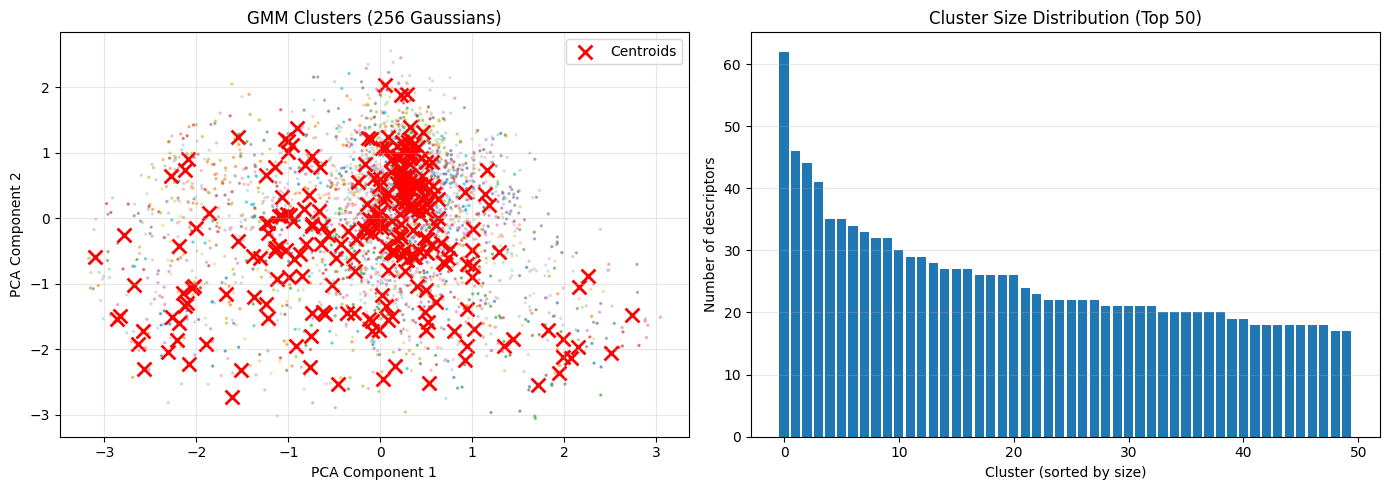

✅ Visualización guardada en ./results/gmm_clusters.png

📊 Estadísticas de clusters:
   - Cluster más grande: 62 descriptores
   - Cluster más pequeño: 1 descriptores
   - Promedio: 12.0 descriptores
   - Desviación estándar: 8.6


In [ ]:
print("\n" + "=" * 80)
print("PARTE 3B: Visualización del vocabulario aprendido")
print("=" * 80)

def visualize_gmm_clusters(gmm, descriptors_pca, n_samples=3000):

    if len(descriptors_pca) > n_samples:
        indices = np.random.choice(len(descriptors_pca), n_samples, replace=False)
        sample = descriptors_pca[indices]
    else:
        sample = descriptors_pca


    labels = gmm.predict(sample)


    fig, axes = plt.subplots(1, 2, figsize=(14, 5))


    scatter = axes[0].scatter(
        sample[:, 0],
        sample[:, 1],
        c=labels,
        cmap='tab20',
        alpha=0.5,
        s=2
    )
    axes[0].set_xlabel('PCA Component 1')
    axes[0].set_ylabel('PCA Component 2')
    axes[0].set_title(f'GMM Clusters ({Config.N_GAUSSIANS} Gaussians)')
    axes[0].grid(True, alpha=0.3)


    means_2d = gmm.means_[:, :2]
    axes[0].scatter(means_2d[:, 0], means_2d[:, 1],
                   c='red', marker='x', s=100, linewidths=2,
                   label='Centroids')
    axes[0].legend()


    unique, counts = np.unique(labels, return_counts=True)
    axes[1].bar(range(len(counts[:50])), sorted(counts, reverse=True)[:50])
    axes[1].set_xlabel('Cluster (sorted by size)')
    axes[1].set_ylabel('Number of descriptors')
    axes[1].set_title('Cluster Size Distribution (Top 50)')
    axes[1].grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.savefig(f'{Config.RESULTS_DIR}/gmm_clusters.png', dpi=150, bbox_inches='tight')
    plt.show()

    print(f"✅ Visualización guardada en {Config.RESULTS_DIR}/gmm_clusters.png")

    # Estadísticas
    print(f"\n📊 Estadísticas de clusters:")
    print(f"   - Cluster más grande: {counts.max()} descriptores")
    print(f"   - Cluster más pequeño: {counts.min()} descriptores")
    print(f"   - Promedio: {counts.mean():.1f} descriptores")
    print(f"   - Desviación estándar: {counts.std():.1f}")

visualize_gmm_clusters(gmm, pooled_descriptors_pca)

In [ ]:
print("\n" + "=" * 80)
print("PARTE 3C: Implementación de Fisher Vector encoding")
print("=" * 80)

class FisherVectorEncoder:

    def __init__(self, gmm, pca):

        self.gmm = gmm
        self.pca = pca
        self.n_gaussians = gmm.n_components
        self.dim = gmm.means_.shape[1]

    def encode(self, descriptors):

        if descriptors is None or len(descriptors) == 0:

            return np.zeros(2 * self.n_gaussians * self.dim)


        descriptors_pca = self.pca.transform(descriptors)


        posteriors = self.gmm.predict_proba(descriptors_pca)


        means = self.gmm.means_
        covariances = self.gmm.covariances_

        fv_mu = np.zeros((self.n_gaussians, self.dim))
        fv_sigma = np.zeros((self.n_gaussians, self.dim))


        for k in range(self.n_gaussians):

            diff = descriptors_pca - means[k]


            diff_norm = diff / np.sqrt(covariances[k] + 1e-7)


            weighted_diff = posteriors[:, k:k+1] * diff_norm


            fv_mu[k] = weighted_diff.sum(axis=0)


            fv_sigma[k] = (posteriors[:, k:k+1] * (diff_norm**2 - 1)).sum(axis=0)


        fv = np.concatenate([fv_mu.flatten(), fv_sigma.flatten()])


        fv = self.normalize(fv)

        return fv

    def normalize(self, fv):

        fv = np.sign(fv) * np.sqrt(np.abs(fv))


        fv = fv / (np.linalg.norm(fv) + 1e-7)

        return fv


fv_encoder = FisherVectorEncoder(gmm, pca)

print(f"✅ Fisher Vector encoder creado")
print(f"   - Dimensionalidad: {2 * Config.N_GAUSSIANS * Config.PCA_DIM}D")
print(f"   - ({Config.N_GAUSSIANS} Gaussians × {Config.PCA_DIM}D × 2 orders)")

print(f"\n🧪 Testing encoder con imagen de ejemplo...")
test_img_tensor, test_label = train_data[0]
test_img_gray = tensor_to_gray(test_img_tensor)
test_descriptors = sift_extractor(test_img_gray)
test_fv = fv_encoder.encode(test_descriptors)

print(f"✅ Test exitoso:")
print(f"   - Descriptores extraídos: {len(test_descriptors)}")
print(f"   - Fisher Vector shape: {test_fv.shape}")
print(f"   - L2 norm: {np.linalg.norm(test_fv):.4f} (debe ser ~1.0)")


PARTE 3C: Implementación de Fisher Vector encoding
✅ Fisher Vector encoder creado
   - Dimensionalidad: 32768D
   - (256 Gaussians × 64D × 2 orders)

🧪 Testing encoder con imagen de ejemplo...
✅ Test exitoso:
   - Descriptores extraídos: 3949
   - Fisher Vector shape: (32768,)
   - L2 norm: 1.0000 (debe ser ~1.0)


In [ ]:
print("\n" + "=" * 80)
print("✅ PARTE 3 COMPLETADA - Visual Vocabulary Training")
print("=" * 80)
print("\n📋 Resumen:")
print(f"  ✓ GMM entrenado: {Config.N_GAUSSIANS} Gaussians")
print(f"  ✓ Covariance type: diagonal (eficiente)")
print(f"  ✓ Fisher Vector encoder implementado")
print(f"  ✓ Dimensionalidad FV: {2 * Config.N_GAUSSIANS * Config.PCA_DIM}D")
print(f"  ✓ Normalización aplicada: power + L2")
print(f"  ✓ Modelo guardado en cache")
print(f"\n🚀 Siguiente paso: Ejecutar Parte 4 - Feature Extraction para Train/Test")
print("=" * 80)


✅ PARTE 3 COMPLETADA - Visual Vocabulary Training

📋 Resumen:
  ✓ GMM entrenado: 256 Gaussians
  ✓ Covariance type: diagonal (eficiente)
  ✓ Fisher Vector encoder implementado
  ✓ Dimensionalidad FV: 32768D
  ✓ Normalización aplicada: power + L2
  ✓ Modelo guardado en cache

🚀 Siguiente paso: Ejecutar Parte 4 - Feature Extraction para Train/Test


#Parte 4 EXTRACCIÓN DE FISHER VECTORS - TRAIN SET

In [ ]:
import numpy as np
import time
from tqdm import tqdm
import joblib

print("=" * 80)
print("PARTE 4A: Extracción de Fisher Vectors - Training Set")
print("=" * 80)

train_features_cache = f'{Config.CACHE_DIR}/train_features_fv{Config.N_GAUSSIANS}.pkl'

if check_cache(train_features_cache):
    print(f"📂 Cargando features de training desde cache...")
    data = load_cache(train_features_cache)
    X_train = data['features']
    y_train = data['labels']
    print(f"✅ Cargado: {X_train.shape[0]} muestras")
else:
    print(f"🔄 Extrayendo Fisher Vectors del training set...")
    print(f"   - Total imágenes: {len(train_data)}")
    print(f"⏱️  Tiempo estimado: {format_time(len(train_data) * 0.8)}")

    start_time = time.time()

    X_train = []
    y_train = []
    failed_count = 0

    for idx in tqdm(range(len(train_data)), desc="Training set"):
        img_tensor, label = train_data[idx]
        img_gray = tensor_to_gray(img_tensor)

        # Extraer descriptores RootSIFT
        descriptors = sift_extractor(img_gray)

        if descriptors is not None and len(descriptors) > 0:
            # Codificar en Fisher Vector
            fv = fv_encoder.encode(descriptors)
            X_train.append(fv)
            y_train.append(label)
        else:
            failed_count += 1


    X_train = np.array(X_train)
    y_train = np.array(y_train)

    elapsed = time.time() - start_time

    save_cache({
        'features': X_train,
        'labels': y_train
    }, train_features_cache)

    print(f"✅ Extracción completada en {format_time(elapsed)}")
    print(f"   - Exitosas: {len(X_train)}/{len(train_data)}")
    print(f"   - Fallidas: {failed_count}")
    print(f"   - Tiempo promedio: {elapsed/len(X_train):.2f}s por imagen")

print(f"\n📊 Training features:")
print(f"   - Shape: {X_train.shape}")
print(f"   - Distribución de clases:")
unique, counts = np.unique(y_train, return_counts=True)
for class_id, count in zip(unique, counts):
    print(f"     {class_names[class_id]:12s}: {count:4d}")

PARTE 4A: Extracción de Fisher Vectors - Training Set
🔄 Extrayendo Fisher Vectors del training set...
   - Total imágenes: 5000
⏱️  Tiempo estimado: 1.1h


Training set: 100%|██████████| 5000/5000 [34:09<00:00,  2.44it/s]


💾 Cache guardado: ./cache/train_features_fv256.pkl
✅ Extracción completada en 34.2m
   - Exitosas: 5000/5000
   - Fallidas: 0
   - Tiempo promedio: 0.41s por imagen

📊 Training features:
   - Shape: (5000, 32768)
   - Distribución de clases:
     airplane    :  500
     bird        :  500
     car         :  500
     cat         :  500
     deer        :  500
     dog         :  500
     horse       :  500
     monkey      :  500
     ship        :  500
     truck       :  500


In [ ]:
print("\n" + "=" * 80)
print("PARTE 4B: Extracción de Fisher Vectors - Test Set")
print("=" * 80)

test_features_cache = f'{Config.CACHE_DIR}/test_features_fv{Config.N_GAUSSIANS}.pkl'

if check_cache(test_features_cache):
    print(f"📂 Cargando features de test desde cache...")
    data = load_cache(test_features_cache)
    X_test = data['features']
    y_test = data['labels']
    print(f"✅ Cargado: {X_test.shape[0]} muestras")
else:
    print(f"🔄 Extrayendo Fisher Vectors del test set...")
    print(f"   - Total imágenes: {len(test_data)}")
    print(f"⏱️  Tiempo estimado: {format_time(len(test_data) * 0.8)}")

    start_time = time.time()

    X_test = []
    y_test = []
    failed_count = 0

    for idx in tqdm(range(len(test_data)), desc="Test set"):
        img_tensor, label = test_data[idx]
        img_gray = tensor_to_gray(img_tensor)

        # Extraer descriptores RootSIFT
        descriptors = sift_extractor(img_gray)

        if descriptors is not None and len(descriptors) > 0:
            # Codificar en Fisher Vector
            fv = fv_encoder.encode(descriptors)
            X_test.append(fv)
            y_test.append(label)
        else:
            failed_count += 1


    X_test = np.array(X_test)
    y_test = np.array(y_test)

    elapsed = time.time() - start_time


    save_cache({
        'features': X_test,
        'labels': y_test
    }, test_features_cache)

    print(f"✅ Extracción completada en {format_time(elapsed)}")
    print(f"   - Exitosas: {len(X_test)}/{len(test_data)}")
    print(f"   - Fallidas: {failed_count}")
    print(f"   - Tiempo promedio: {elapsed/len(X_test):.2f}s por imagen")

print(f"\n📊 Test features:")
print(f"   - Shape: {X_test.shape}")
print(f"   - Distribución de clases:")
unique, counts = np.unique(y_test, return_counts=True)
for class_id, count in zip(unique, counts):
    print(f"     {class_names[class_id]:12s}: {count:4d}")


PARTE 4B: Extracción de Fisher Vectors - Test Set
🔄 Extrayendo Fisher Vectors del test set...
   - Total imágenes: 8000
⏱️  Tiempo estimado: 1.8h


Test set: 100%|██████████| 8000/8000 [54:15<00:00,  2.46it/s]


💾 Cache guardado: ./cache/test_features_fv256.pkl
✅ Extracción completada en 54.3m
   - Exitosas: 8000/8000
   - Fallidas: 0
   - Tiempo promedio: 0.41s por imagen

📊 Test features:
   - Shape: (8000, 32768)
   - Distribución de clases:
     airplane    :  800
     bird        :  800
     car         :  800
     cat         :  800
     deer        :  800
     dog         :  800
     horse       :  800
     monkey      :  800
     ship        :  800
     truck       :  800



PARTE 4C: Análisis de features extraídas

📊 Análisis de Train Features:
   - Shape: (5000, 32768)
   - Dimensionalidad: 32768
   - Dtype: float64

   Estadísticas de valores:
   - Min: -0.1092
   - Max: 0.1601
   - Mean: -0.0002
   - Std: 0.0055

   Normas L2:
   - Mean: 1.0000
   - Std: 0.0000
   - Min: 1.0000
   - Max: 1.0000

   Sparsity: 10.69% zeros


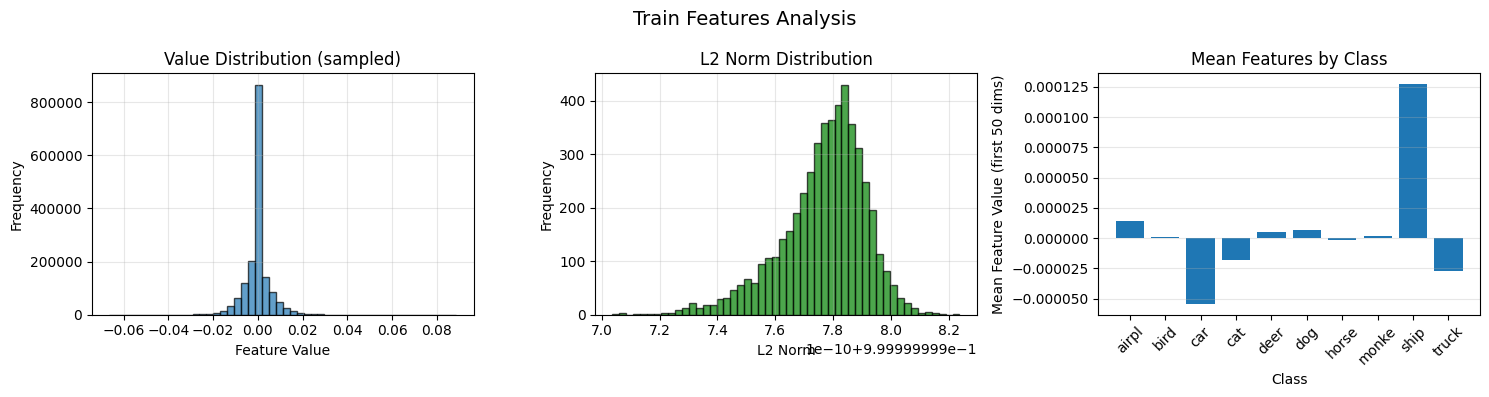

✅ Visualización guardada en ./results/train features_analysis.png

📊 Análisis de Test Features:
   - Shape: (8000, 32768)
   - Dimensionalidad: 32768
   - Dtype: float64

   Estadísticas de valores:
   - Min: -0.1292
   - Max: 0.1705
   - Mean: -0.0002
   - Std: 0.0055

   Normas L2:
   - Mean: 1.0000
   - Std: 0.0000
   - Min: 1.0000
   - Max: 1.0000

   Sparsity: 10.63% zeros


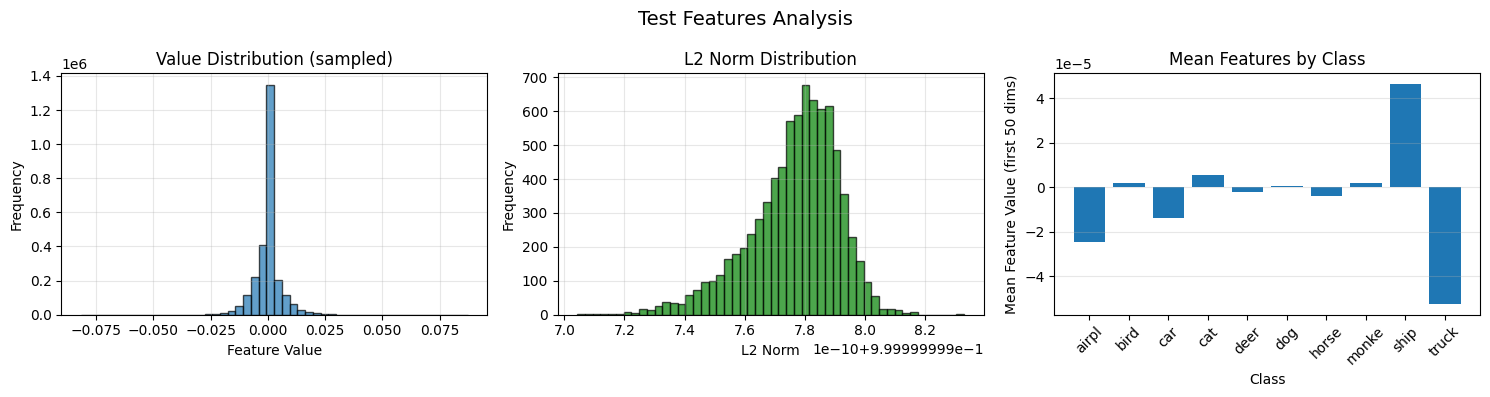

✅ Visualización guardada en ./results/test features_analysis.png


In [ ]:
print("\n" + "=" * 80)
print("PARTE 4C: Análisis de features extraídas")
print("=" * 80)

def analyze_features(X, y, name="Features"):

    print(f"\n📊 Análisis de {name}:")
    print(f"   - Shape: {X.shape}")
    print(f"   - Dimensionalidad: {X.shape[1]}")
    print(f"   - Dtype: {X.dtype}")


    print(f"\n   Estadísticas de valores:")
    print(f"   - Min: {X.min():.4f}")
    print(f"   - Max: {X.max():.4f}")
    print(f"   - Mean: {X.mean():.4f}")
    print(f"   - Std: {X.std():.4f}")


    norms = np.linalg.norm(X, axis=1)
    print(f"\n   Normas L2:")
    print(f"   - Mean: {norms.mean():.4f}")
    print(f"   - Std: {norms.std():.4f}")
    print(f"   - Min: {norms.min():.4f}")
    print(f"   - Max: {norms.max():.4f}")


    zeros = (np.abs(X) < 1e-10).sum()
    total = X.size
    sparsity = zeros / total * 100
    print(f"\n   Sparsity: {sparsity:.2f}% zeros")


    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    fig.suptitle(f'{name} Analysis', fontsize=14)


    axes[0].hist(X.flatten()[::100], bins=50, alpha=0.7, edgecolor='black')
    axes[0].set_xlabel('Feature Value')
    axes[0].set_ylabel('Frequency')
    axes[0].set_title('Value Distribution (sampled)')
    axes[0].grid(True, alpha=0.3)


    axes[1].hist(norms, bins=50, alpha=0.7, color='green', edgecolor='black')
    axes[1].set_xlabel('L2 Norm')
    axes[1].set_ylabel('Frequency')
    axes[1].set_title('L2 Norm Distribution')
    axes[1].grid(True, alpha=0.3)


    mean_per_class = []
    for class_id in range(10):
        mask = (y == class_id)
        if mask.sum() > 0:
            mean_per_class.append(X[mask].mean(axis=0)[:50].mean())
        else:
            mean_per_class.append(0)

    axes[2].bar(range(10), mean_per_class)
    axes[2].set_xlabel('Class')
    axes[2].set_ylabel('Mean Feature Value (first 50 dims)')
    axes[2].set_title('Mean Features by Class')
    axes[2].set_xticks(range(10))
    axes[2].set_xticklabels([c[:5] for c in class_names], rotation=45)
    axes[2].grid(True, alpha=0.3, axis='y')

    plt.tight_layout()
    plt.savefig(f'{Config.RESULTS_DIR}/{name.lower()}_analysis.png', dpi=150, bbox_inches='tight')
    plt.show()

    print(f"✅ Visualización guardada en {Config.RESULTS_DIR}/{name.lower()}_analysis.png")


analyze_features(X_train, y_train, name="Train Features")


analyze_features(X_test, y_test, name="Test Features")


In [ ]:
print("\n" + "=" * 80)
print("PARTE 4D: Verificación de calidad de features")
print("=" * 80)

def check_feature_quality(X_train, X_test):

    issues = []


    if np.isnan(X_train).any() or np.isnan(X_test).any():
        issues.append("❌ Detectados valores NaN")
    else:
        print("✅ No hay valores NaN")

    if np.isinf(X_train).any() or np.isinf(X_test).any():
        issues.append("❌ Detectados valores Inf")
    else:
        print("✅ No hay valores Inf")


    if X_train.max() > 100 or X_train.min() < -100:
        issues.append(f"⚠️  Rango de valores muy amplio: [{X_train.min():.2f}, {X_train.max():.2f}]")
    else:
        print(f"✅ Rango de valores apropiado: [{X_train.min():.2f}, {X_train.max():.2f}]")


    var = X_train.var(axis=0)
    low_var = (var < 1e-6).sum()
    if low_var > X_train.shape[1] * 0.1:
        issues.append(f"⚠️  {low_var} dimensiones con varianza muy baja")
    else:
        print(f"✅ Varianza apropiada en {X_train.shape[1] - low_var}/{X_train.shape[1]} dimensiones")

    # Check 4: Normas L2 (deben estar alrededor de 1.0 después de normalización)
    norms_train = np.linalg.norm(X_train, axis=1)
    norms_test = np.linalg.norm(X_test, axis=1)

    if abs(norms_train.mean() - 1.0) > 0.1:
        issues.append(f"⚠️  Norma L2 promedio train: {norms_train.mean():.3f} (esperado ~1.0)")
    else:
        print(f"✅ Norma L2 promedio train: {norms_train.mean():.3f}")

    if abs(norms_test.mean() - 1.0) > 0.1:
        issues.append(f"⚠️  Norma L2 promedio test: {norms_test.mean():.3f} (esperado ~1.0)")
    else:
        print(f"✅ Norma L2 promedio test: {norms_test.mean():.3f}")

    # Resumen
    if len(issues) == 0:
        print(f"\n✅ Todas las verificaciones pasadas - Features de buena calidad")
    else:
        print(f"\n⚠️  Se encontraron {len(issues)} problemas:")
        for issue in issues:
            print(f"   {issue}")

check_feature_quality(X_train, X_test)


PARTE 4D: Verificación de calidad de features
✅ No hay valores NaN
✅ No hay valores Inf
✅ Rango de valores apropiado: [-0.11, 0.16]
✅ Varianza apropiada en 32485/32768 dimensiones
✅ Norma L2 promedio train: 1.000
✅ Norma L2 promedio test: 1.000

✅ Todas las verificaciones pasadas - Features de buena calidad


In [ ]:
print("\n" + "=" * 80)
print("✅ PARTE 4 COMPLETADA - Feature Extraction")
print("=" * 80)
print("\n📋 Resumen:")
print(f"  ✓ Train features: {X_train.shape}")
print(f"  ✓ Test features: {X_test.shape}")
print(f"  ✓ Dimensionalidad: {X_train.shape[1]}D")
print(f"  ✓ Features normalizadas (L2 norm ≈ 1.0)")
print(f"  ✓ Calidad verificada - listas para clasificación")
print(f"  ✓ Features guardadas en cache")
print(f"\n🚀 Siguiente paso: Ejecutar Parte 5 - Training y Evaluación de Clasificador")
print("=" * 80)


✅ PARTE 4 COMPLETADA - Feature Extraction

📋 Resumen:
  ✓ Train features: (5000, 32768)
  ✓ Test features: (8000, 32768)
  ✓ Dimensionalidad: 32768D
  ✓ Features normalizadas (L2 norm ≈ 1.0)
  ✓ Calidad verificada - listas para clasificación
  ✓ Features guardadas en cache

🚀 Siguiente paso: Ejecutar Parte 5 - Training y Evaluación de Clasificador


#Parte 5

In [ ]:
import numpy as np
import time
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import (accuracy_score, classification_report,
                             confusion_matrix, f1_score)
import matplotlib.pyplot as plt
import seaborn as sns
import joblib

print("=" * 80)
print("PARTE 5A: Training de clasificador SVM con Grid Search")
print("=" * 80)

classifier_cache = f'{Config.CACHE_DIR}/svm_classifier_fv{Config.N_GAUSSIANS}.pkl'

if check_cache(classifier_cache):
    print(f"📂 Cargando clasificador desde cache...")
    best_svm = load_cache(classifier_cache)
    print(f"✅ Clasificador cargado")
else:
    print(f"🔄 Training SVM con Grid Search...")
    print(f"   - Algoritmo: LinearSVC (eficiente para alta dimensionalidad)")
    print(f"   - Parámetros: C = {Config.SVM_C_VALUES}")
    print(f"⏱️  Tiempo estimado: {format_time(len(Config.SVM_C_VALUES) * 60)}")

    start_time = time.time()


    base_svm = LinearSVC(
        dual=False,
        max_iter=1000,
        random_state=Config.RANDOM_SEED,
        verbose=0
    )


    param_grid = {'C': Config.SVM_C_VALUES}

    grid_search = GridSearchCV(
        base_svm,
        param_grid,
        cv=3,  # 3-fold cross-validation
        scoring='accuracy',
        verbose=2,
        n_jobs=-1
    )

    # Entrenar
    grid_search.fit(X_train, y_train)

    best_svm = grid_search.best_estimator_

    elapsed = time.time() - start_time

    # Guardar modelo
    save_cache(best_svm, classifier_cache)

    print(f"\n✅ Training completado en {format_time(elapsed)}")
    print(f"   - Mejor C: {grid_search.best_params_['C']}")
    print(f"   - Mejor CV accuracy: {grid_search.best_score_:.4f} ({grid_search.best_score_*100:.2f}%)")

    print(f"\n📊 Resultados del Grid Search:")
    results = grid_search.cv_results_
    for mean_score, params in zip(results['mean_test_score'], results['params']):
        print(f"   C={params['C']:6.2f} → Accuracy: {mean_score:.4f} ({mean_score*100:.2f}%)")

PARTE 5A: Training de clasificador SVM con Grid Search
🔄 Training SVM con Grid Search...
   - Algoritmo: LinearSVC (eficiente para alta dimensionalidad)
   - Parámetros: C = [0.1, 1, 10, 100]
⏱️  Tiempo estimado: 4.0m
Fitting 3 folds for each of 4 candidates, totalling 12 fits
💾 Cache guardado: ./cache/svm_classifier_fv256.pkl

✅ Training completado en 8.6m
   - Mejor C: 1
   - Mejor CV accuracy: 0.7458 (74.58%)

📊 Resultados del Grid Search:
   C=  0.10 → Accuracy: 0.7166 (71.66%)
   C=  1.00 → Accuracy: 0.7458 (74.58%)
   C= 10.00 → Accuracy: 0.7440 (74.40%)
   C=100.00 → Accuracy: 0.7434 (74.34%)


In [ ]:
print("\n" + "=" * 80)
print("PARTE 5B: Evaluación en Test Set")
print("=" * 80)

print(f"🔄 Prediciendo en test set...")
start_time = time.time()

y_pred = best_svm.predict(X_test)

elapsed = time.time() - start_time
print(f"✅ Predicción completada en {format_time(elapsed)}")


test_accuracy = accuracy_score(y_test, y_pred)
test_f1_macro = f1_score(y_test, y_pred, average='macro')

print(f"\n🎯 RESULTADOS FINALES:")
print("=" * 60)
print(f"📊 Test Accuracy:    {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")
print(f"📊 Macro F1-Score:   {test_f1_macro:.4f}")
print("=" * 60)

print(f"\n📋 Classification Report:")
print(classification_report(y_test, y_pred, target_names=class_names, digits=4))



PARTE 5B: Evaluación en Test Set
🔄 Prediciendo en test set...
✅ Predicción completada en 0.1s

🎯 RESULTADOS FINALES:
📊 Test Accuracy:    0.7604 (76.04%)
📊 Macro F1-Score:   0.7590

📋 Classification Report:
              precision    recall  f1-score   support

    airplane     0.8745    0.8712    0.8729       800
        bird     0.7135    0.6725    0.6924       800
         car     0.9008    0.8962    0.8985       800
         cat     0.6270    0.6262    0.6266       800
        deer     0.7452    0.7350    0.7401       800
         dog     0.5890    0.5375    0.5621       800
       horse     0.7410    0.8225    0.7796       800
      monkey     0.6493    0.6550    0.6521       800
        ship     0.8881    0.9125    0.9001       800
       truck     0.8557    0.8750    0.8653       800

    accuracy                         0.7604      8000
   macro avg     0.7584    0.7604    0.7590      8000
weighted avg     0.7584    0.7604    0.7590      8000




PARTE 5C: Visualización de resultados


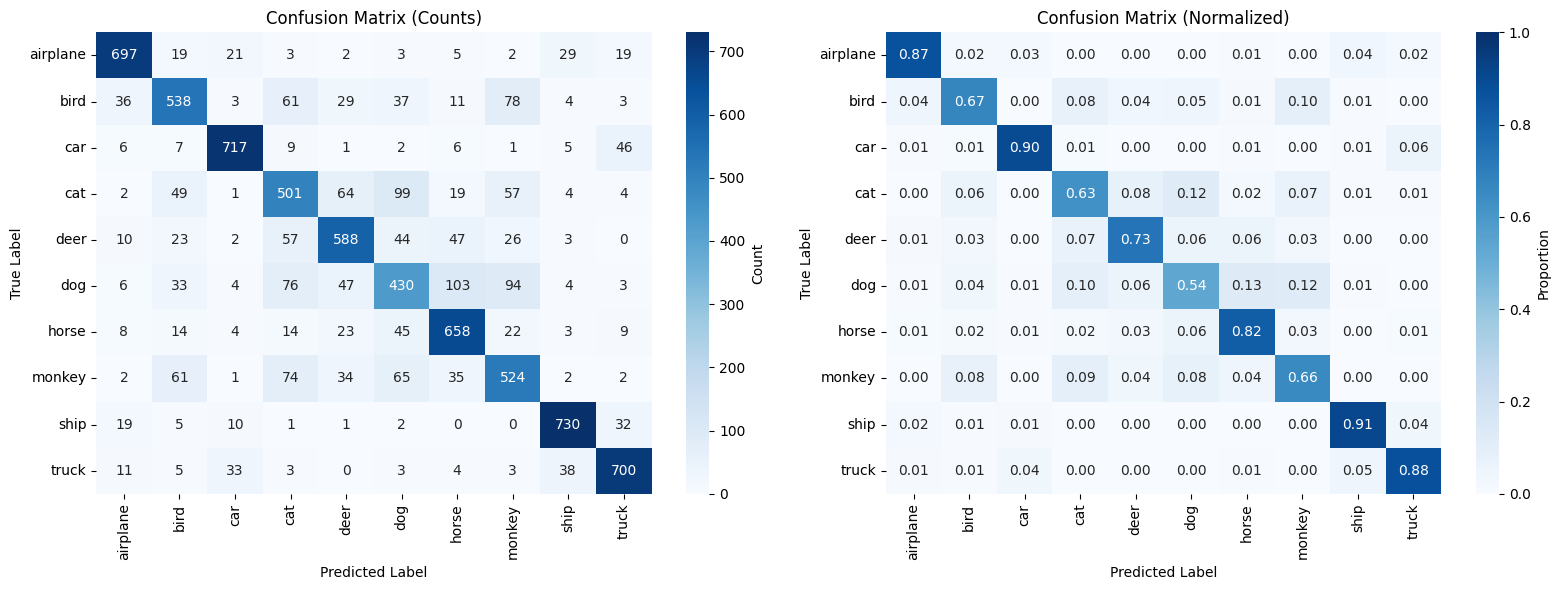

✅ Matriz de confusión guardada en ./results/confusion_matrix.png


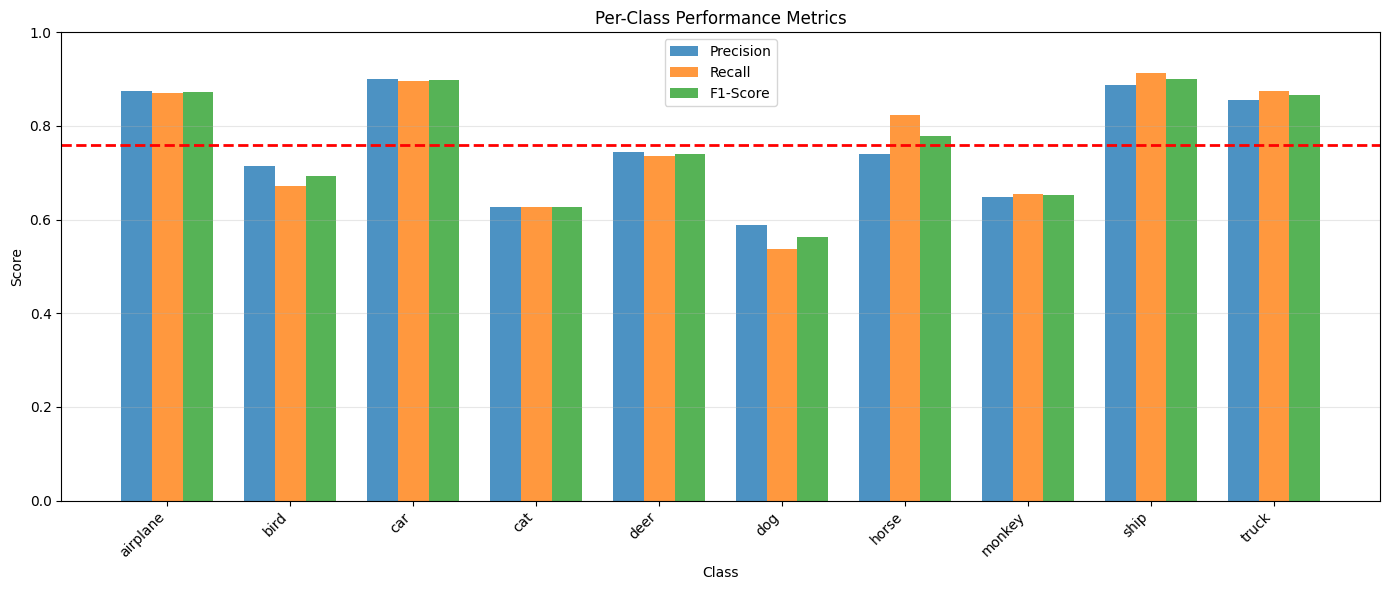

✅ Performance por clase guardada en ./results/per_class_performance.png

🏆 Top 3 clases (por F1-score):
   ship        : F1=0.9001, Precision=0.8881, Recall=0.9125
   car         : F1=0.8985, Precision=0.9008, Recall=0.8962
   airplane    : F1=0.8729, Precision=0.8745, Recall=0.8712

⚠️  Bottom 3 clases (por F1-score):
   dog         : F1=0.5621, Precision=0.5890, Recall=0.5375
   cat         : F1=0.6266, Precision=0.6270, Recall=0.6262
   monkey      : F1=0.6521, Precision=0.6493, Recall=0.6550


In [ ]:
print("\n" + "=" * 80)
print("PARTE 5C: Visualización de resultados")
print("=" * 80)

def plot_confusion_matrix(y_true, y_pred, class_names):

    cm = confusion_matrix(y_true, y_pred)


    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))


    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                ax=axes[0], cbar_kws={'label': 'Count'})
    axes[0].set_title('Confusion Matrix (Counts)')
    axes[0].set_ylabel('True Label')
    axes[0].set_xlabel('Predicted Label')

    sns.heatmap(cm_normalized, annot=True, fmt='.2f', cmap='Blues',
                xticklabels=class_names, yticklabels=class_names,
                ax=axes[1], cbar_kws={'label': 'Proportion'}, vmin=0, vmax=1)
    axes[1].set_title('Confusion Matrix (Normalized)')
    axes[1].set_ylabel('True Label')
    axes[1].set_xlabel('Predicted Label')

    plt.tight_layout()
    plt.savefig(f'{Config.RESULTS_DIR}/confusion_matrix.png', dpi=150, bbox_inches='tight')
    plt.show()

    print(f"✅ Matriz de confusión guardada en {Config.RESULTS_DIR}/confusion_matrix.png")

    return cm

cm = plot_confusion_matrix(y_test, y_pred, class_names)

def plot_per_class_performance(y_true, y_pred, class_names):

    from sklearn.metrics import precision_recall_fscore_support

    precision, recall, f1, support = precision_recall_fscore_support(
        y_true, y_pred, average=None
    )

    x = np.arange(len(class_names))
    width = 0.25

    fig, ax = plt.subplots(figsize=(14, 6))

    bars1 = ax.bar(x - width, precision, width, label='Precision', alpha=0.8)
    bars2 = ax.bar(x, recall, width, label='Recall', alpha=0.8)
    bars3 = ax.bar(x + width, f1, width, label='F1-Score', alpha=0.8)

    ax.set_xlabel('Class')
    ax.set_ylabel('Score')
    ax.set_title('Per-Class Performance Metrics')
    ax.set_xticks(x)
    ax.set_xticklabels(class_names, rotation=45, ha='right')
    ax.legend()
    ax.grid(True, alpha=0.3, axis='y')
    ax.set_ylim([0, 1])


    ax.axhline(y=test_accuracy, color='r', linestyle='--',
               linewidth=2, label=f'Overall Accuracy: {test_accuracy:.3f}')

    plt.tight_layout()
    plt.savefig(f'{Config.RESULTS_DIR}/per_class_performance.png', dpi=150, bbox_inches='tight')
    plt.show()

    print(f"✅ Performance por clase guardada en {Config.RESULTS_DIR}/per_class_performance.png")

    print(f"\n🏆 Top 3 clases (por F1-score):")
    top_indices = np.argsort(f1)[-3:][::-1]
    for idx in top_indices:
        print(f"   {class_names[idx]:12s}: F1={f1[idx]:.4f}, Precision={precision[idx]:.4f}, Recall={recall[idx]:.4f}")

    print(f"\n⚠️  Bottom 3 clases (por F1-score):")
    bottom_indices = np.argsort(f1)[:3]
    for idx in bottom_indices:
        print(f"   {class_names[idx]:12s}: F1={f1[idx]:.4f}, Precision={precision[idx]:.4f}, Recall={recall[idx]:.4f}")

plot_per_class_performance(y_test, y_pred, class_names)


In [ ]:
print("\n" + "=" * 80)
print("PARTE 5D: Análisis de errores")
print("=" * 80)

def analyze_errors(y_true, y_pred, class_names):
    errors = (y_true != y_pred)
    n_errors = errors.sum()
    error_rate = n_errors / len(y_true) * 100

    print(f"❌ Total errores: {n_errors}/{len(y_true)} ({error_rate:.2f}%)")

    print(f"\n🔀 Top 10 confusiones más frecuentes:")
    confusion_pairs = {}
    for true_label, pred_label in zip(y_true[errors], y_pred[errors]):
        pair = (true_label, pred_label)
        confusion_pairs[pair] = confusion_pairs.get(pair, 0) + 1

    sorted_pairs = sorted(confusion_pairs.items(), key=lambda x: x[1], reverse=True)

    for i, ((true_idx, pred_idx), count) in enumerate(sorted_pairs[:10], 1):
        true_name = class_names[true_idx]
        pred_name = class_names[pred_idx]
        percentage = count / n_errors * 100
        print(f"   {i:2d}. {true_name:10s} → {pred_name:10s}: {count:3d} ({percentage:5.2f}% de errores)")

    return errors

errors_mask = analyze_errors(y_test, y_pred, class_names)


PARTE 5D: Análisis de errores
❌ Total errores: 1917/8000 (23.96%)

🔀 Top 10 confusiones más frecuentes:
    1. dog        → horse     : 103 ( 5.37% de errores)
    2. cat        → dog       :  99 ( 5.16% de errores)
    3. dog        → monkey    :  94 ( 4.90% de errores)
    4. bird       → monkey    :  78 ( 4.07% de errores)
    5. dog        → cat       :  76 ( 3.96% de errores)
    6. monkey     → cat       :  74 ( 3.86% de errores)
    7. monkey     → dog       :  65 ( 3.39% de errores)
    8. cat        → deer      :  64 ( 3.34% de errores)
    9. bird       → cat       :  61 ( 3.18% de errores)
   10. monkey     → bird      :  61 ( 3.18% de errores)


In [ ]:
print("\n" + "=" * 80)
print("PARTE 5E: Cross-Validation en Training Set")
print("=" * 80)

print(f"🔄 Ejecutando 5-fold cross-validation...")
cv_scores = cross_val_score(best_svm, X_train, y_train, cv=5,
                            scoring='accuracy', n_jobs=-1)

print(f"✅ Cross-validation completado")
print(f"\n📊 Resultados por fold:")
for i, score in enumerate(cv_scores, 1):
    print(f"   Fold {i}: {score:.4f} ({score*100:.2f}%)")

print(f"\n📊 Resumen:")
print(f"   - Mean CV Accuracy: {cv_scores.mean():.4f} ({cv_scores.mean()*100:.2f}%)")
print(f"   - Std CV Accuracy:  {cv_scores.std():.4f}")
print(f"   - Min: {cv_scores.min():.4f}, Max: {cv_scores.max():.4f}")


PARTE 5E: Cross-Validation en Training Set
🔄 Ejecutando 5-fold cross-validation...
✅ Cross-validation completado

📊 Resultados por fold:
   Fold 1: 0.7490 (74.90%)
   Fold 2: 0.7440 (74.40%)
   Fold 3: 0.7610 (76.10%)
   Fold 4: 0.7670 (76.70%)
   Fold 5: 0.7530 (75.30%)

📊 Resumen:
   - Mean CV Accuracy: 0.7548 (75.48%)
   - Std CV Accuracy:  0.0083
   - Min: 0.7440, Max: 0.7670


In [ ]:
print("\n" + "=" * 80)
print("PARTE 5F: Guardando resultados finales")
print("=" * 80)

results = {
    'test_accuracy': test_accuracy,
    'test_f1_macro': test_f1_macro,
    'cv_scores': cv_scores,
    'cv_mean': cv_scores.mean(),
    'cv_std': cv_scores.std(),
    'confusion_matrix': cm,
    'y_test': y_test,
    'y_pred': y_pred,
    'config': {
        'n_gaussians': Config.N_GAUSSIANS,
        'pca_dim': Config.PCA_DIM,
        'sift_scales': Config.SIFT_SCALES,
        'sift_stride': Config.SIFT_STRIDE,
        'best_C': best_svm.C
    }
}

results_path = f'{Config.RESULTS_DIR}/final_results.pkl'
save_cache(results, results_path)
print(f"💾 Resultados guardados en {results_path}")

with open(f'{Config.RESULTS_DIR}/results_summary.txt', 'w') as f:
    f.write("STL-10 Classical Vision - Fisher Vectors Results\n")
    f.write("=" * 60 + "\n\n")
    f.write(f"Test Accuracy:     {test_accuracy:.4f} ({test_accuracy*100:.2f}%)\n")
    f.write(f"Macro F1-Score:    {test_f1_macro:.4f}\n")
    f.write(f"CV Mean Accuracy:  {cv_scores.mean():.4f} ± {cv_scores.std():.4f}\n\n")
    f.write("Configuration:\n")
    f.write(f"  - GMM Gaussians:  {Config.N_GAUSSIANS}\n")
    f.write(f"  - PCA dimension:  {Config.PCA_DIM}\n")
    f.write(f"  - SIFT scales:    {Config.SIFT_SCALES}\n")
    f.write(f"  - SIFT stride:    {Config.SIFT_STRIDE}\n")
    f.write(f"  - SVM C:          {best_svm.C}\n")

print(f"📄 Resumen guardado en {Config.RESULTS_DIR}/results_summary.txt")



PARTE 5F: Guardando resultados finales
💾 Cache guardado: ./results/final_results.pkl
💾 Resultados guardados en ./results/final_results.pkl
📄 Resumen guardado en ./results/results_summary.txt
